# City of Boston Payroll Analysis - Part 1: Data Wrangling

Employee earnings data is available for City of Boston employees from 2011 to 2017.  Roughly 20,000 employees and earnings are classified by department, job title, “regular” or “overtime”, zip code and a few other criteria.

In [1]:
%matplotlib notebook

# import modules
import numpy as np
import pandas as pd
import re, os, glob
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("darkgrid")
sns.set_context("notebook")

SyntaxError: invalid syntax (<ipython-input-1-3068f0f11976>, line 10)

## Read data, and basic fixes

In [2]:
# read file(s)
path = os.getcwd()                    
all_files = glob.glob(os.path.join(path, "employee*.csv"))  

column_names = ['name', 'department', 'title', 'regular', 'retro', 'other', 'overtime', 'injured',\
                'detail', 'quinn', 'total', 'zip']
df_from_each_file = (pd.read_csv(f, delimiter=',', encoding = "ISO-8859-1", header=0, names=column_names, \
                                 index_col=None).assign(year=f) for f in all_files)  # read year from filename 
earnings   = pd.concat(df_from_each_file, ignore_index=True)
earnings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152544 entries, 0 to 152543
Data columns (total 13 columns):
name          152544 non-null object
department    152544 non-null object
title         152544 non-null object
regular       151356 non-null object
retro         111927 non-null object
other         134181 non-null object
overtime      121726 non-null object
injured       110914 non-null object
detail        113100 non-null object
quinn         110802 non-null object
total         152544 non-null object
zip           152536 non-null object
year          152544 non-null object
dtypes: object(13)
memory usage: 15.1+ MB


A complete set of names/employees, departments, titles and total earnings are availble for the years 2011-2017. Some fields are blank due to no earnings in that particular category. Number columns are given as strings with preceding "$" symbol. Cells are blank where no earnings are reported. 8 zipcodes are missing. The basic cleaning steps are:

1. Extract year from path (filename of earnings report) and assign to new column "year"
2. Columns "department" and "title" are in reverse order for 2013 and 2014
3. Zipcodes are 5 digits for some years, 5 + 4 for other years and only 4 digits in 2017 where the leading "0" has been dropped
4. Missing zipcodes can be filled by comparing to previous year's employee entry
5. Add checkpoint to confirm complete set of 5 digit zipcodes
6. Fill empty number cells with "0"
7. Convert all numbers to numeric dtype

In [3]:
# extract year from filename
earnings['year'] = earnings['year'].replace({'\D':''}, regex=True) 
earnings['year'] = earnings['year'].str[-4:]  # remove any numbers from file path

# switch "department" and "title" columns for 2013 and 2014
earnings.loc[earnings.year.isin(['2013', '2014']),['department','title']] = \
        earnings.loc[earnings.year.isin(['2013', '2014']),['title','department']].values
    
# add leading zero for 4 digit zip codes
earnings['zip'] = np.where(earnings['zip'].str.len() == 4, '0' + earnings['zip'], earnings['zip'])

# missing zip codes
earnings.loc[earnings['zip'].str.len() < 4, 'zip'] = np.NaN
earnings['zip'] = earnings.sort_values(by='name')['zip'].fillna(method='ffill')

# ignore "+4" zip codes
earnings['zip'] = earnings['zip'].str[:5]

# convert number strings to numeric dtype
number_columns = ['regular', 'retro', 'other', 'overtime', 'injured', 'detail', 'quinn', 'total']
earnings[number_columns] = earnings[number_columns].replace({'\$': '', ',': ''}, regex=True)\
                                .apply(pd.to_numeric, errors='coerce').fillna(0, axis=1)

## Consolidate department names

There are roughly 1400 unique job titles - a plausible number. Interestingly there is a sharp increase in department names starting in 2014. The city's website lists only 72 departments. The difference appears to be due to a detailed breakdown of the public school department.

<IPython.core.display.Javascript object>


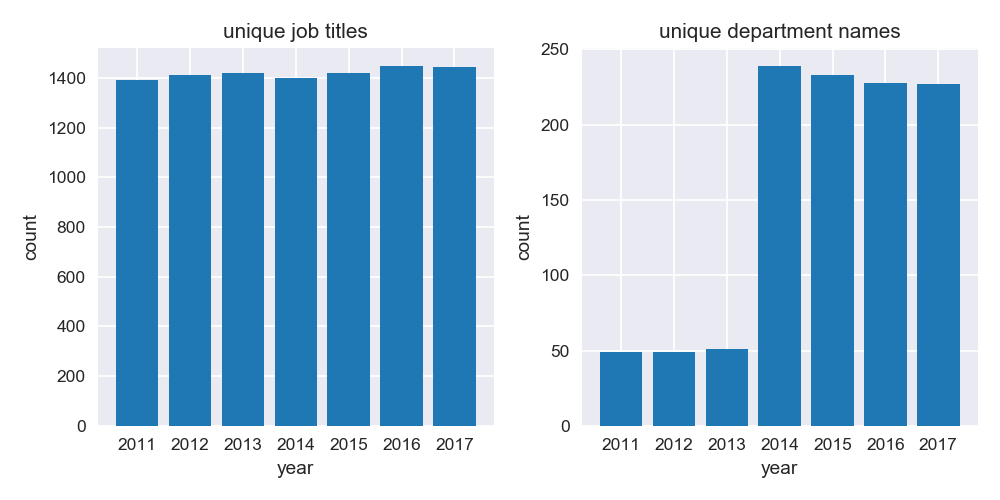

In [4]:
# unique job titles and departments by year
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.bar(earnings['year'].unique(), earnings.groupby('year')['title'].nunique())
ax1.set_title('unique job titles')
ax1.set_ylabel('count')
ax1.set_xlabel('year')

ax2.bar(earnings['year'].unique(), earnings.groupby('year')['department'].nunique())
ax2.set_title('unique department names')
ax2.set_ylabel('count')
ax2.set_xlabel('year')

plt.tight_layout()
plt.show()

In [5]:
# combine all school departments into a single "Boston Public Schools" department

earnings['dept_clean'] = earnings['department'] # all others to stay the same
earnings['dept_clean'] = np.where(earnings.department.astype(str).str[:3] == \
                                  'BPS', 'Boston Public Schools', earnings.dept_clean)
earnings['dept_clean'] = np.where(earnings.department.astype(str).str[:10] == \
                                  'Asst Super', 'Boston Public Schools', earnings.dept_clean)

bps = ['K-8', 'EEC', 'ELC', 'Middle', 'School', 'Academy', 'Elementary', 'Greenwood', 
       'E Leadership Acad', 'UP Academy Dorchester', 'UP "Unlocking Potential" Acad', 
       'Lyon Pilot High 9-12', 'Ellison/Parks EES', 'Chief Academic Officer', 
       'UP Academy Holland', 'Achievement Gap', 'English Language Learn', 'Haley Pilot',
       'Greater Egleston High', 'Early Learning Services', 'Career & Technical Ed', 
       'Teaching & Learning', 'Unified Student Svc', 'Superintendent',
       'Student Support Svc', 'Harbor High', 'Fam & Student Engagemt', 
       'Enrollment Services', 'Food & Nutrition Svc', 'HPEC: Com Acd Science & Health',
       'Institutional Advancemt', 'Legal Advisor', 'Professional Developmnt', 
       'Chief Operating Officer', 'Research Assess & Eval', 'Info & Instr Technology',
       'BTU Pilot', 'Boston Collaborative High Sch', 'Diplomas Plus', 'Chief Financial Officer']
for school in bps:
    earnings['dept_clean'] = np.where(earnings.department.astype(str).str[-len(school):] == \
                                      school, 'Boston Public Schools', earnings.dept_clean)


New departments in 2017:

In [6]:
print(set(earnings.dept_clean.loc[earnings.year == '2017'].unique()) - \
      set(earnings.dept_clean.loc[earnings.year == '2016'].unique()))

{'Advancement & Ext. Affairs', 'Chief of Staff'}


Further consolidation of departments would be difficult without further information from the city. 

Taking a look at the department sizes from year to year shows a number of department name changes. These will be adjusted using the 2017 names.

In [7]:
"""
Rename various departments to 2017 name:

""" 

dept_names = {'Transportation Department': 'Traffic Division',
              'Dept of Voter Mobilization': 'Election Division',
              'State Boston Retirement Syst': 'Boston Retirement System',
              'Youth Fund': 'Youth Engagement & Employment',
              'Administration and Finance': 'Office of Admin & Finance',
              'Office of Finance & Budget': 'Office of Admin & Finance',
              'Office Of Civil Rights': 'Fair Housing & Equity',
              'Small & Local Business': 'Office of Economic Development',
              'Ofc Chf Public Works Transport': 'Office of Streets',
              'Ofc of Strts, Trnsp & Sani': 'Office of Streets',
              'Property Management': 'Public Facilities Department',
              'Mayor\'s Office-Public Info': 'Mayor\'s Office',
              'Arts & Cultural Development': 'Office of Arts & Culture',
              'Accountability': 'Licensing Board',
              'Women\'s Commission': 'Women\'s Advancement'}
for d in dept_names:
    earnings['dept_clean'] = np.where(earnings['department'].str[-len(d):] == \
                                 d, dept_names[d], earnings.dept_clean)


<IPython.core.display.Javascript object>


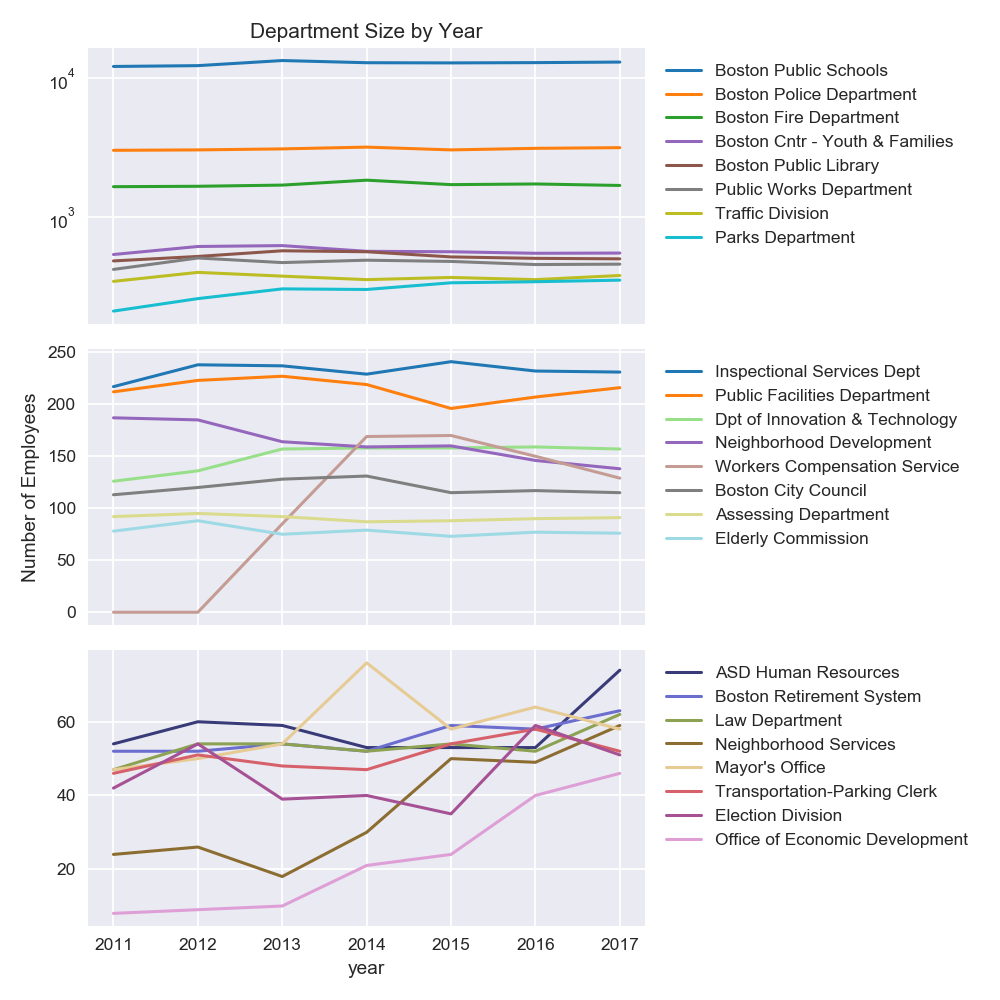

In [8]:
# pivot to obtain number of employees in each department by year
departments = pd.pivot_table(earnings, values='name', index='dept_clean',  columns='year', aggfunc='count')\
                    .sort_values('2017', ascending=False).fillna(0)

# spread over 3 sub plots for better visibility
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(8, 8), sharex=True)
ax1.set_title('Department Size by Year')
departments.iloc[:8].T.plot(ax=ax1, cmap='tab10') # large departments with log scale
ax1.set_yscale('log')
departments.iloc[8:16].T.plot(ax=ax2, cmap='tab20') # medium departments
departments.iloc[16:24].T.plot(ax=ax3, cmap='tab20b') # small departments
ax2.set_ylabel('Number of Employees')
ax1.legend(bbox_to_anchor=(1.01, 1.0))
ax2.legend(bbox_to_anchor=(1.01, 1.0))
ax3.legend(bbox_to_anchor=(1.01, 1.0))
ax3.set_xticklabels(['none', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])

plt.tight_layout()
plt.show()

Increased variance in the lower chart can be explained by the small number of employees where a small change can have a bigger impact. Nonetheless it could be interesting to look at the spike in the mayor's office in 2014 - mayor Marty Walsh's first year in office. Another interesting observation is the spike in the election division in the presidential election years 2012 and 2016.

## Consolidate Job Titles

A closer look at the job titles shows some data cleaning might be helpful as well. Fortunately the school department titles look reasonably clean, however the police, fire and library departments could use some work. The Pareto rule will be applied again to limit further investigation of job titles.

### Police Department Titles

Below is an example of inconsistent entries in the titles field. The "$" symbols followed by numbers at the end of the titles appear to be errors, but don't affect the rest of the data.

In [9]:
# police titles:
police_titles = earnings.loc[(earnings.department == 'Boston Police Department')\
                            & (earnings.title.str.startswith('Police O'))\
                            & (earnings.year == '2017')]\
                            ['title'].value_counts()
print(police_titles)

Police Officer                    1331
Police Offc Comm Serv Offc 3$8      51
Police Offc Mobile Offc 2$6         42
Police Offc Acad Instr 2$6          29
Police Offc/FgrPrt Ev Tch 4$10      25
Police Offc/Juvenile Offc 4$10      19
Police Offc Canine 2$6              17
Police Officer Hdq Dispatch         16
Police Offc Harborboat 3$8          14
Police Offc Hackney Invest 3$8      14
Police Offc/Auto Invest 4$10        12
Police Offc/Bomb Squad              11
Police Offc Ballistician 4$10        8
Police Offc Canine Offc 2$6          8
Police Offc Bomb Squad               7
Police Offc/Hosp Liaison 4$10        5
Police Officer Harborboat 3$8        4
Police Officer Mobile Oper 2$6       2
Police Offc Breath $13.50            1
Name: title, dtype: int64


In [10]:
"""
More information can be found here:
https://en.wikipedia.org/wiki/Boston_Police_Department#Departmental_organization

Police dectives are police officers who perform detective work

"""

# consolidate police department titles

earnings['title_clean'] = earnings['title'] # all others to stay the same
pol = {'Police Of': 'Police Officer', 
#         'Police De': 'Police Officer',
        'Police Se': 'Police Sergeant',
        'PoliceSer': 'Police Sergeant',
        'Police Li': 'Police Lieutenant',
        'Police Ca': 'Police Captain',
        'Police Li': 'Police Lieutenant'}
for p in pol:
    earnings['title_clean'] = np.where(earnings.title.str[:9] == p, pol[p], earnings.title_clean)

<IPython.core.display.Javascript object>


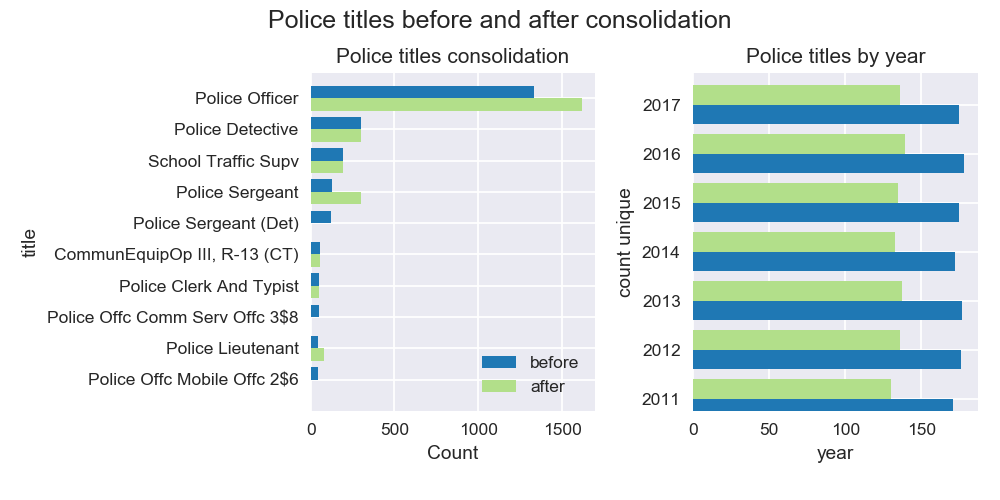

In [11]:
# Display before and after stats

# most common police department titles before adjustment:
before = earnings['title'][(earnings.department == 'Boston Police Department') \
                                        & (earnings.year == '2017')] \
                                        .value_counts() \
                                        .nlargest(10) \
                                        .reset_index() 
# after adjustment
after = earnings['title_clean'][(earnings.department == 'Boston Police Department') \
                                        & (earnings.year == '2017')] \
                                        .value_counts() \
                                        .nlargest(10) \
                                        .reset_index() 
# combine and sort    
joined = pd.merge(before, after, how='left') \
                        .fillna(0) \
                        .sort_values(by=['title'], ascending=False) \
                        .rename(index=str, columns={'index': 'title', 'title': 'before', 'title_clean': 'after'})

# data by year
titles_by_year = pd.pivot_table(earnings[earnings['dept_clean'] == 'Boston Police Department'],\
                            values=['title', 'title_clean'], columns='year', aggfunc=pd.Series.nunique) \
                        .sort_values(by='2017', ascending=False)[:10] \
                        .transpose() \
                        .reset_index()

# plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle('Police titles before and after consolidation')

joined.plot.barh('title', 'before', ax=ax1, width=0.4, color='#1f78b4', position=1).invert_yaxis()
joined.plot.barh('title', 'after', ax=ax1, width=0.4, color='#b2df8a', position=0).invert_yaxis()
ax1.set_title('Police titles consolidation')
ax1.set_xlabel('Count')
ax1.set_ylim(10, -0.8)

titles_by_year.plot('year', 'title', kind='barh', ax=ax2, width=0.4, color='#1f78b4', position=1, label='before', legend=False)
titles_by_year.plot('year', 'title_clean', kind='barh', ax=ax2, width=0.4, color='#b2df8a', position=0, label='after', legend=False)
ax2.set_title('Police titles by year')
ax2.set_xlabel('year')
ax2.set_ylabel('count unique')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Fire Department Titles

In [12]:
# consolidate fire department titles

fd = {'FF': 'Fire Fighter', 
      'Fire Fi': 'Fire Fighter',
      'FireFig': 'Fire Fighter',
      'Fire Ca': 'Fire Captain',
      'Fire L': 'Fire Lieutenant',
      'FireLi': 'Fire Lieutenant',
      'Distric': 'District Fire Chief',
      'Dist Fi': 'District Fire Chief',
      'DistFCh': 'District Fire Chief',
      'Dep Fir': 'Dep Fire Chief',
      'DepFire': 'Dep Fire Chief'}

for k in fd:
    earnings['title_clean'] = np.where(earnings.title.astype(str).str[:len(k)] == k, fd[k], earnings.title_clean)

earnings['title_clean'] = np.where((earnings.title.str[:10] == 'Sr Admin A') \
                                   & (earnings.dept_clean == 'Boston Fire Department'),\
                                   'Sr Admin (Fire)', earnings.title_clean)

fd_titles = earnings.title_clean.loc[(earnings.dept_clean == 'Boston Fire Department')]
print('Number of unique job titles in fire department:', len(set(fd_titles)))
print(fd_titles.value_counts().nlargest(10))

Number of unique job titles in fire department: 104
Fire Fighter                      7971
Fire Lieutenant                   1605
Fire Captain                       545
District Fire Chief                390
Fire Alarm Operator                144
Sr Admin (Fire)                    122
Dep Fire Chief                     117
Head Clerk                          77
Hvy Mtr Equip Repairperson BFD      45
Sr Fire Alarm Operator              43
Name: title_clean, dtype: int64


<IPython.core.display.Javascript object>


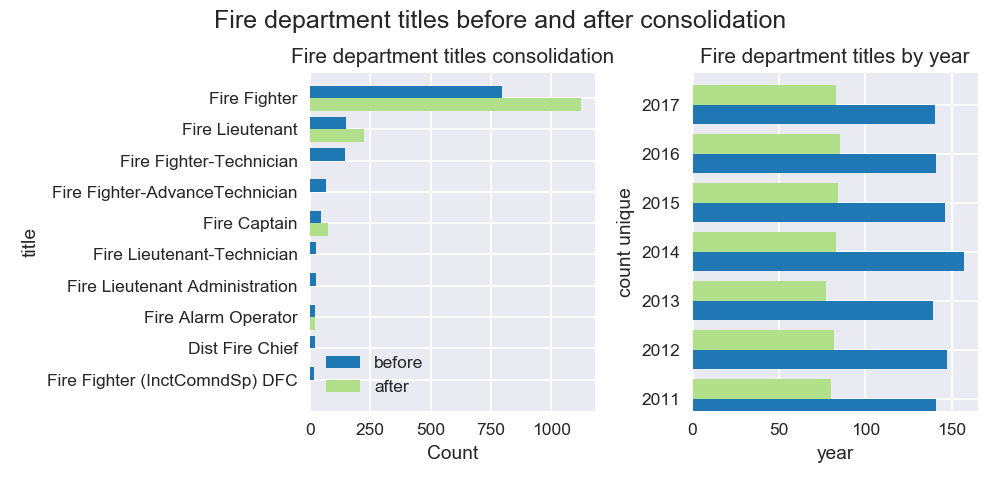

In [13]:
# Display before and after stats

# most common police department titles before adjustment:
before = earnings['title'][(earnings.department == 'Boston Fire Department') \
                                        & (earnings.year == '2017')] \
                                        .value_counts() \
                                        .nlargest(10) \
                                        .reset_index() 
# after adjustment
after = earnings['title_clean'][(earnings.department == 'Boston Fire Department') \
                                        & (earnings.year == '2017')] \
                                        .value_counts() \
                                        .nlargest(10) \
                                        .reset_index() 
# combine and sort    
joined = pd.merge(before, after, how='left') \
                        .fillna(0) \
                        .sort_values(by=['title'], ascending=False) \
                        .rename(index=str, columns={'index': 'title', 'title': 'before', 'title_clean': 'after'})

# data by year
titles_by_year = pd.pivot_table(earnings[earnings['dept_clean'] == 'Boston Fire Department'],\
                            values=['title', 'title_clean'], columns='year', aggfunc=pd.Series.nunique) \
                        .sort_values(by='2017', ascending=False)[:10] \
                        .transpose() \
                        .reset_index()

# plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle('Fire department titles before and after consolidation')

joined.plot.barh('title', 'before', ax=ax1, width=0.4, color='#1f78b4', position=1).invert_yaxis()
joined.plot.barh('title', 'after', ax=ax1, width=0.4, color='#b2df8a', position=0).invert_yaxis()
ax1.set_title('Fire department titles consolidation')
ax1.set_xlabel('Count')
ax1.set_ylim(10, -0.8)

titles_by_year.plot('year', 'title', kind='barh', ax=ax2, width=0.4, color='#1f78b4', position=1, label='before', legend=False)
titles_by_year.plot('year', 'title_clean', kind='barh', ax=ax2, width=0.4, color='#b2df8a', position=0, label='after', legend=False)
ax2.set_title('Fire department titles by year')
ax2.set_xlabel('year')
ax2.set_ylabel('count unique')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Library titles

In [14]:
library = {'Spec Library Asst': 'Spec Library Asst',
       'Sr Library Asst': 'Sr Library Asst',
       'Librarian': 'Librarian',
       'Special Library': 'Spec Library Asst',
       'Spec Collection L': 'Librarian',
       'Collection Libr': 'Librarian'}
for k in library:
    earnings['title_clean'] = np.where(earnings.title.str.contains(k), library[k], earnings.title_clean)

bpl_titles = earnings.title_clean.loc[(earnings.dept_clean == 'Boston Public Library')]
print('Number of unique job titles in Boston Public Library:', len(set(bpl_titles)))
print(bpl_titles.value_counts().nlargest(20))

Number of unique job titles in Boston Public Library: 149
Librarian                         781
Spec Library Asst                 575
Sr Library Asst                   564
Library Aide                      504
Sr Bldg Custodian                 154
Jr Building Custodian             100
Prin Library Asst                  45
Generalist II                      40
Technical Support Associate        30
Curator-Professional Lib IV        28
Generalist I                       27
Sr Clerk                           23
Cataloger And Classifier I         22
Laborer                            21
Cataloger And Classifier II        20
Asst Neighborhood Services Mgr     19
Programs & Comm Outreach Libr      18
Technical Specialist               18
Staff Officer-Special Projects     15
Clerk                              15
Name: title_clean, dtype: int64


<IPython.core.display.Javascript object>


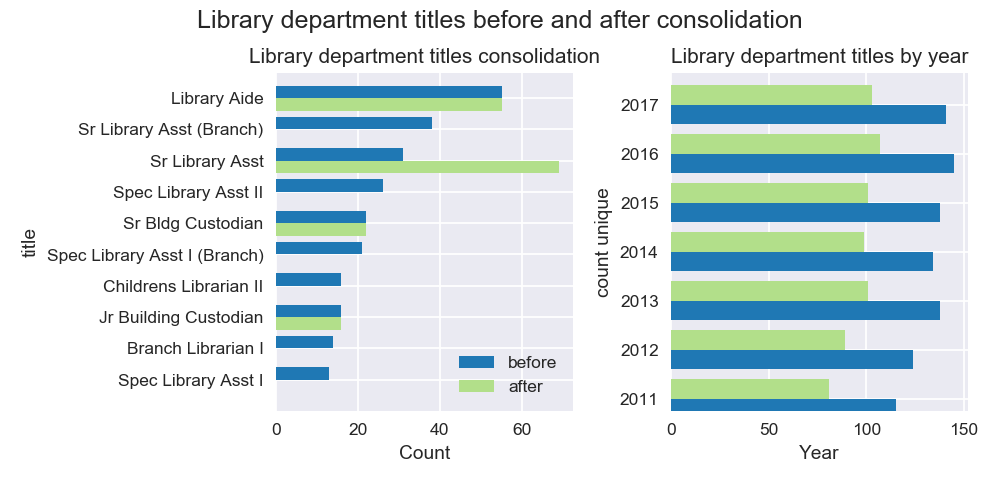

In [15]:
# Display before and after stats

# most common police department titles before adjustment:
before = earnings['title'][(earnings.department == 'Boston Public Library') \
                                        & (earnings.year == '2017')] \
                                        .value_counts() \
                                        .nlargest(10) \
                                        .reset_index() 
# after adjustment
after = earnings['title_clean'][(earnings.department == 'Boston Public Library') \
                                        & (earnings.year == '2017')] \
                                        .value_counts() \
                                        .nlargest(10) \
                                        .reset_index() 
# combine and sort    
joined = pd.merge(before, after, how='left') \
                        .fillna(0) \
                        .sort_values(by=['title'], ascending=False) \
                        .rename(index=str, columns={'index': 'title', 'title': 'before', 'title_clean': 'after'})

# data by year
titles_by_year = pd.pivot_table(earnings[earnings['dept_clean'] == 'Boston Public Library'],\
                            values=['title', 'title_clean'], columns='year', aggfunc=pd.Series.nunique) \
                        .sort_values(by='2017', ascending=False)[:10] \
                        .transpose() \
                        .reset_index()

# plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle('Library department titles before and after consolidation')

joined.plot.barh('title', 'before', ax=ax1, width=0.4, color='#1f78b4', position=1).invert_yaxis()
joined.plot.barh('title', 'after', ax=ax1, width=0.4, color='#b2df8a', position=0).invert_yaxis()
ax1.set_title('Library department titles consolidation')
ax1.set_xlabel('Count')
ax1.set_ylim(10, -0.8)

titles_by_year.plot('year', 'title', kind='barh', ax=ax2, width=0.4, color='#1f78b4', position=1, label='before', legend=False)
titles_by_year.plot('year', 'title_clean', kind='barh', ax=ax2, width=0.4, color='#b2df8a', position=0, label='after', legend=False)
ax2.set_title('Library department titles by year')
ax2.set_xlabel('Year')
ax2.set_ylabel('count unique')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


<IPython.core.display.Javascript object>


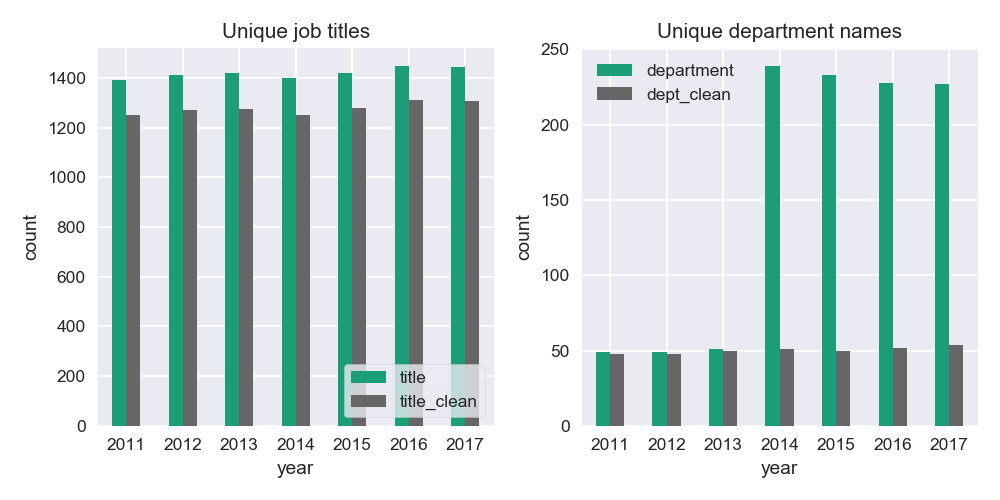

In [16]:
# unique job titles and departments by year
title_gb = earnings.groupby('year')[['title', 'title_clean']].nunique()
dept_gb = earnings.groupby('year')[['department', 'dept_clean']].nunique()

# plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
title_gb.plot.bar(ax=ax1, cmap='Dark2', rot=0)
ax1.set_title('Unique job titles')
ax1.set_ylabel('count')
ax1.set_xlabel('year')
ax1.legend(loc=4, frameon=True, framealpha=0.8)

dept_gb.plot.bar(ax=ax2, cmap='Dark2', rot=0)
ax2.set_title('Unique department names')
ax2.set_ylabel('count')
ax2.set_xlabel('year')

plt.tight_layout()
plt.show()

In [17]:
# save combined data to file
earnings.to_csv('earnings.csv', index=False)